In [1]:
from sklearn.model_selection import StratifiedKFold
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from diagnostics.evaluation import rev_weighted_quad_kappa
from diagnostics.evaluation import fit_and_eval, rev_weighted_quad_kappa, rmse, error_rate
from imputers.zero_filler import ZeroFiller
from tools.datasets import get_boston, get_heart, get_houses, get_prudential
from config import *
from transformers import BoxCoxTransformer, LabelsClipper, OutliersClipper, CustomOneHotEncoder, CustomBinner, CustomBinaryBinner, FeatureDropper
import warnings
warnings.filterwarnings('ignore')

In [2]:
# cv = KFold(3, shuffle=True, random_state=0)
# scorer = mean_squared_error
# data, labels, continuous, discrete, dummy, categorical, target = get_boston()
# data, labels, continuous, discrete, dummy, categorical, target = get_houses()
# predictors = [LinearRegression()]

# scorer = accuracy_score
# data, labels, continuous, discrete, dummy, categorical, target = get_heart()
# predictors = [LogisticRegression()]
# cv = StratifiedKFold(3, labels)

scorer = rev_weighted_quad_kappa
data, labels, continuous, discrete, dummy, categorical, target = get_prudential()
cv = StratifiedKFold(3)
predictors = [LabelsClipper(regressor=LinearRegression())]

train = data.drop(target, axis=1)

In [ ]:
# BINNER_CONFIG = { col: {'values': [train[col].max()]} for col in continuous + discrete }  # houses
# BINNER_CONFIG = { col: {'bins': 3} for col in continuous + discrete }                               # heart
BINNER_CONFIG = { col: {'bins': 5} for col in continuous }                                          # prudential
# BINNER_CONFIG = { col: {'bins': 5} for col in continuous + discrete }                               # boston (or none)

In [16]:
BOX_COX = BOX_COX_P
model = Pipeline([
        ('onehot',       CustomOneHotEncoder(columns=categorical)),
        ('clipper', OutliersClipper(continuous)),
        ('binner', CustomBinaryBinner({})),
        ('binner2', CustomBinaryBinner({})),
        ('zero_filler',  ZeroFiller()),
        ('boxcox', BoxCoxTransformer(BOX_COX)),
        ('scaler', StandardScaler()),
        ('predictor',   None)  
])

In [17]:

params = [
    { # BASELINE
        'clipper': [None],
        'binner': [None],
        'binner2': [None],
        'boxcox': [None],
        'scaler': [None],
        'predictor': predictors
    },
    { # BINNER
        'clipper': [None],
        'binner': [
            CustomBinner(BINNER_CONFIG_PRUD)
        ],
        'binner__nan': [True, False],
        'binner__drop': [True, False],
        'binner2': [None],
        'boxcox': [None],
        'scaler': [None],
        'predictor': predictors
    },
    { # BINNER Binary
        'clipper': [None],
        'binner': [
            CustomBinaryBinner(BINARY_BINNER_CONFIG_PRUD)
        ],
        'binner__nan': [True, False],
        'binner__drop': [True, False],
        'binner2': [None],
        'boxcox': [None],
        'scaler': [None],
        'predictor': predictors
    },
]

In [18]:
start = time()
grid = GridSearchCV(model, cv=cv, n_jobs=-1, param_grid=params, scoring=make_scorer(scorer))
grid.fit(train.copy(), labels)
end = time()

In [21]:
import numpy
numpy.set_printoptions(threshold=numpy.nan)
print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (end - start, len(grid.cv_results_['params'])))
print(grid.grid_scores_)


GridSearchCV took 218.70 seconds for 9 candidate parameter settings.
[mean: 0.46263, std: 0.00805, params: {'binner': None, 'binner2': None, 'boxcox': None, 'clipper': None, 'predictor': LabelsClipper(regressor=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)), 'scaler': None}, mean: 0.45416, std: 0.00493, params: {'binner': CustomBinner(configuration={'Medical_History_1': {'values': [0, 240], 'bins': [0, 1, 10, 30, 100, 200, 240]}, 'Medical_History_10': {'values': [0, 240], 'bins': [0, 1, 2, 240]}, 'Medical_History_15': {'values': [0, 240], 'bins': [0, 1, 2, 240]}, 'Medical_History_24': {'values': [0, 240], 'bins': [0, 1, 2, 240]}, 'Medical_History_32': {'values': [0, 240], 'bins': [0, 1, 2, 240]}},
       drop=False, nan=False), 'binner2': None, 'binner__drop': True, 'binner__nan': True, 'boxcox': None, 'clipper': None, 'predictor': LabelsClipper(regressor=LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)), 'scaler': None}, mean:

In [48]:
max_std = grid.cv_results_['std_test_score'].max()
min_score = grid.cv_results_['mean_test_score'].min()
max_score = grid.cv_results_['mean_test_score'].max()

In [41]:
data = {'baseline': None, 'binner': {}, 'binary binner': {}}
for score, std in zip(grid.grid_scores_,grid.cv_results_['std_test_score'] ):
    if not score.parameters['binner']:
        data['baseline'] = {
            'basic': {
                'mean': score.mean_validation_score,
                'std': std,
            }
        }
    elif isinstance(score.parameters['binner'], CustomBinner):
        labels = []
        if score.parameters['binner__nan']:
            labels.append('nan')
        if score.parameters['binner__drop']:
            labels.append('drop')
        if labels:
            label = ', '.join(labels)
        else:
            label = 'basic'
        data['binner'][label] ={
                'mean': score.mean_validation_score,
                'std': std,
        }
    elif isinstance(score.parameters['binner'], CustomBinaryBinner):
        labels = []
        if score.parameters['binner__nan']:
            labels.append('nan')
        if score.parameters['binner__drop']:
            labels.append('drop')
        if labels:
            label = ', '.join(labels)
        else:
            label = 'basic'
        data['binary binner'][label] = {
                'mean': score.mean_validation_score,
                'std': std,
        }

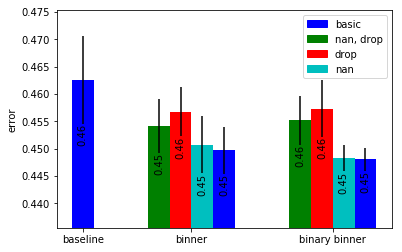

In [55]:

plot_results(data, save_path="./results/fig.png", precision=2, ymax=1.01*max_score+max_std, ymin=0.99*min_score-max_std)

In [54]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

W = 0.5
W2 = 0.2
W3 = 0.2

def plot_results(data, title=None, ylabel='error', save_path=None, ymax=None, ymin=None, precision=4):
    fig = plt.figure()
    COLORS = 'bgrcmyk'
    legend = {}
    i = 0
    for model, settings in data.items():
        for setting in settings.keys():
            if setting not in legend:
                legend[setting] = COLORS[i % len(COLORS)]
                i += 1
    ticks = []
    offsets = []
    offset = 0
    for model, settings in data.items():
        offset += W
        ticks.append(model)
        offsets.append(offset + (len(settings) + 1) * W3 / 2.0)
        for setting, results in settings.items():
            offset += W2
            plt.bar(offset, results['mean'], yerr=results['std'], width=W3, color=legend[setting])
            plt.text(offset, results['mean'] - results['std'], "{num:.{pr}f}".format(num=results['mean'], pr=precision), ha='center', va='top', rotation='vertical')

    if ymax != None:
        plt.ylim(ymax=ymax)
    if ymin != None:
        plt.ylim(ymin=ymin)

    if title:
        plt.title(title)
    plt.xticks(offsets, ticks)
    if ylabel:
        plt.ylabel(ylabel)
    plt.legend(handles=[mpatches.Patch(color=c, label=l) for l, c in legend.items()], loc='best')
    plt.show()

    if save_path:
        fig.savefig(save_path)